# Housing Prices Dataset Playground

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

### Load the dataset

In [2]:
dataset = pd.read_csv('train_housing.csv')
dataset.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Let's see which values correlate the most with the price of the property

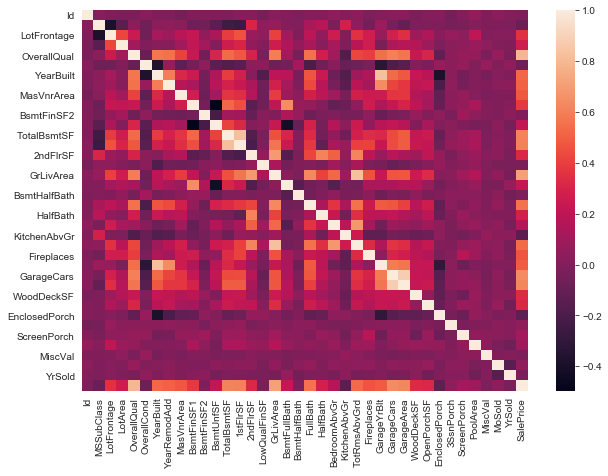

In [3]:
plt.figure(figsize=(10,7))
sns.heatmap(dataset.corr())

### Dataset clean up

In [4]:
numerical_columns = dataset._get_numeric_data().columns
categorical_columns = list(set(dataset.columns) - set(numerical_columns))

#### Missing data

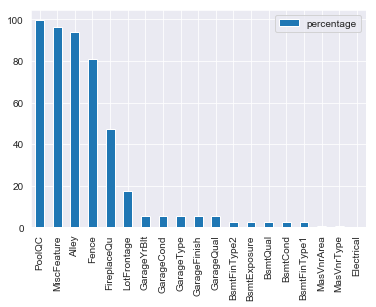

In [5]:
missing_data = pd.DataFrame(
    {
        'percentage': dataset.isnull().sum() / len(dataset) * 100
    }
).sort_values(by='percentage', ascending=False)
missing_data = missing_data[missing_data['percentage'] > 0]
missing_data.plot.bar()

In [6]:
numerical_missing = list(set(missing_data.index) - set(categorical_columns))
for column in numerical_missing:
    dataset[column].fillna(dataset[column].mean(), inplace=True)

The rest of the NaNs will disappear during the next stage 

### Feature mining

In [7]:
# Encoding categorical data as hot vectors
dataset = dataset.join(pd.get_dummies(dataset[categorical_columns]))
dataset.drop(columns=categorical_columns, inplace=True)

dataset['BuildingAge'] = dataset['YrSold'] - dataset['YearBuilt']

dataset.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,Electrical_Mix,Electrical_SBrkr,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,CentralAir_N,CentralAir_Y,BuildingAge
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,1,0,0,0,0,1,0,1,5
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,0,1,0,0,0,0,1,0,1,31
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,1,0,0,0,0,1,0,1,7
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,1,0,0,0,0,1,0,1,91
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,0,1,0,0,0,0,1,0,1,8


### Data visualization

(0, 140)

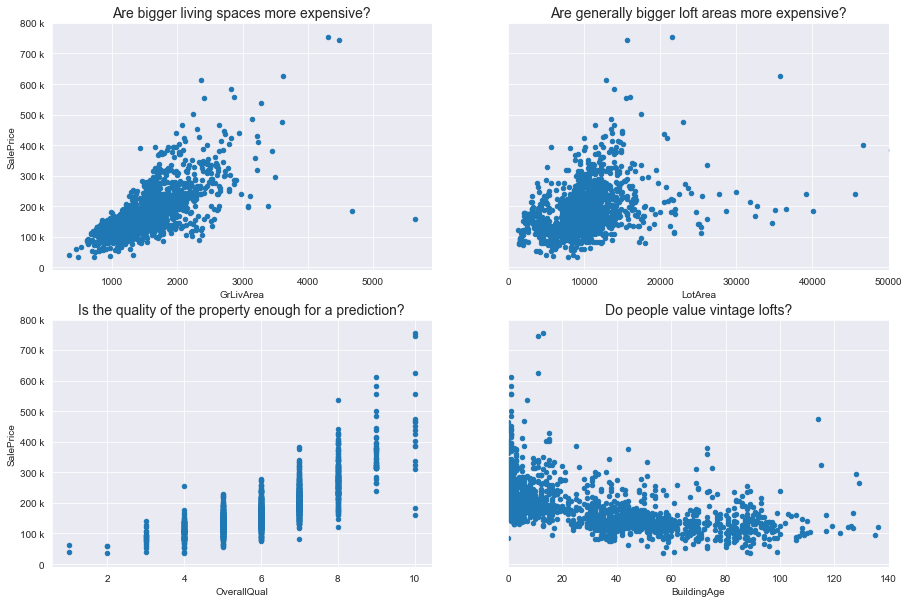

In [8]:
from matplotlib.ticker import EngFormatter

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10), sharey=True)

ax = dataset.plot.scatter(x='GrLivArea', y='SalePrice', ax=axes[0,0])
ax.yaxis.set_major_formatter(EngFormatter(unit=u""))
axes[0,0].set_title("Are bigger living spaces more expensive?", fontsize=14)

dataset.plot.scatter(x='LotArea', y='SalePrice', ax=axes[0,1])
axes[0,1].set_title("Are generally bigger loft areas more expensive?", fontsize=14)
axes[0,1].set_xlim(0, 50000)

dataset.plot.scatter(x='OverallQual', y='SalePrice', ax=axes[1,0])
axes[1,0].set_title("Is the quality of the property enough for a prediction?", fontsize=14)

dataset.plot.scatter(x='BuildingAge', y='SalePrice', ax=axes[1,1])
axes[1,1].set_title("Do people value vintage lofts?", fontsize=14)
axes[1,1].set_xlim(0, 140)

The skewness of the sale price before      1.880940746034036
The skewness of the sale price after       0.1212103673013655


Text(0.5, 1.0, 'Living area distribution')

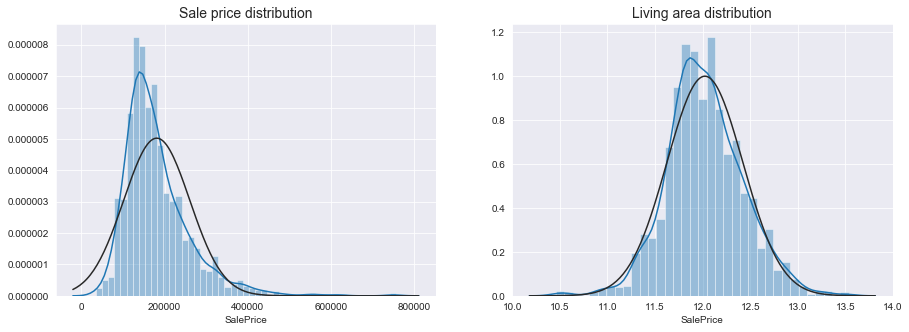

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

sns.distplot(dataset['SalePrice'], fit=stats.norm, ax=axes[0])
axes[0].set_title("Sale price distribution", fontsize=14)

print("The skewness of the sale price before      {}".format(stats.skew(dataset['SalePrice'])))
dataset['SalePrice'] = np.log(dataset['SalePrice'])
print("The skewness of the sale price after       {}".format(stats.skew(dataset['SalePrice'])))

sns.distplot(dataset['SalePrice'], fit=stats.norm, ax=axes[1])
axes[1].set_title("Living area distribution", fontsize=14)

### Splitting the data into training and test

In [10]:
training_size = int(dataset.shape[0] * 0.9)
X_train = dataset.drop(columns='SalePrice')
X_train = X_train.head(training_size).values
y_train = dataset['SalePrice'].head(training_size).values

test_size = int(dataset.shape[0] - training_size)
X_test = dataset.drop(columns='SalePrice')
X_test = X_test.tail(test_size).reset_index(drop = True).values
y_test = np.exp(dataset['SalePrice'].tail(test_size).reset_index(drop = True).values)

print("Training dataset size:   {}".format(training_size))
print("Testing dataset size:    {}".format(test_size))

Training dataset size:   1314
Testing dataset size:    146


In [11]:
from sklearn.metrics import mean_squared_log_error

def RSMLE(y_true, y_pred): 
    """ Root square meat log error """
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

#### Least squares regression

In [12]:
def fitOLS(X, y):
    """ Fit ordinary least squares model to the data """
    return np.linalg.pinv(X) @ y

def fitRidge(X, y, reg_strength):
    """ Fit ridge regression model to the data """
    return np.linalg.inv(X.T @ X  + reg_strength * np.identity(len(X.T))) @ (X.T @ y)

def predict(X, w):
    """ Generate predictions for the given samples """
    return X @ w

In [13]:
# Ordinary least squares regression
W = fitOLS(X_train, y_train)
y_pred = predict(X_test, W)

print('RMSLE Ordinary Least Squares Regression:   {}'.format(RSMLE(y_test, np.exp(np.abs(y_pred)))))

RMSLE Ordinary Least Squares Regression:   0.1501550562837392


In [14]:
# Ridge regression
W = fitRidge(X_train, y_train, 1e2)
y_pred = predict(X_test, W)

print('RMSLE Ridge Regression:   {}'.format(RSMLE(y_test, np.exp(y_pred))))

RMSLE Ridge Regression:   0.1325650241112037


#### Kudos go to:
1. https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard